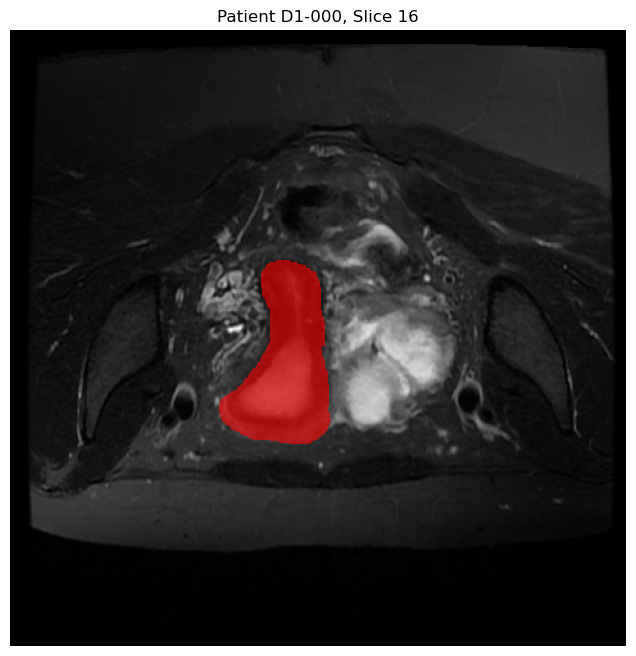

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the path to the data, going up one directory level first
data_root = '../data/UT-EndoMRI'
patient_id = 'D1-000'
patient_path = os.path.join(data_root, 'D1_MHS', patient_id)

# Construct file paths for the MRI scan and the segmentation mask
mri_path = os.path.join(patient_path, f'{patient_id}_T2.nii.gz')
mask_path = os.path.join(patient_path, f'{patient_id}_ut_r1.nii.gz')

# Load the NIfTI files using SimpleITK
mri_image = sitk.ReadImage(mri_path)
mask_image = sitk.ReadImage(mask_path)

# Convert the SimpleITK images to NumPy arrays to work with them
mri_array = sitk.GetArrayFromImage(mri_image)
mask_array = sitk.GetArrayFromImage(mask_image)

# The data is in (depth, height, width) format. Let's pick a slice from the middle.
slice_index = mri_array.shape[0] // 2
mri_slice = mri_array[slice_index, :, :]
mask_slice = mask_array[slice_index, :, :]

# Create a masked version of the segmentation for overlaying
# This makes the zero-values in the mask transparent
masked_slice = np.ma.masked_where(mask_slice == 0, mask_slice)

# Display the images
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(mri_slice, cmap='gray')
ax.imshow(masked_slice, cmap='autumn', alpha=0.6)
ax.set_title(f'Patient {patient_id}, Slice {slice_index}')
ax.axis('off')
plt.show()

In [3]:
# Cell 2: Dataset Overview

data_root = '../data/UT-EndoMRI'
d1_path = os.path.join(data_root, 'D1_MHS')
d2_path = os.path.join(data_root, 'D2_TCPW')

d1_patients = sorted([p for p in os.listdir(d1_path) if os.path.isdir(os.path.join(d1_path, p))])
d2_patients = sorted([p for p in os.listdir(d2_path) if os.path.isdir(os.path.join(d2_path, p))])

print(f"Found {len(d1_patients)} patients in D1_MHS.")
print(f"First 5 patients in D1: {d1_patients[:5]}\n")

print(f"Found {len(d2_patients)} patients in D2_TCPW.")
print(f"First 5 patients in D2: {d2_patients[:5]}")

Found 51 patients in D1_MHS.
First 5 patients in D1: ['D1-000', 'D1-001', 'D1-002', 'D1-003', 'D1-004']

Found 73 patients in D2_TCPW.
First 5 patients in D2: ['D2-000', 'D2-001', 'D2-002', 'D2-003', 'D2-004']


MHS vs. TCPW

The D1_MHS and D2_TCPW folders correspond to the two different hospitals where the data was collected: Memorial Hermann Hospital System (MHS) and Texas Children’s Hospital Pavilion for Women (TCPW).

Analogy: Think of it like getting photos from two different photographers. Even if they're shooting the same subject, they might use different cameras, lenses, and lighting. The result is that the pictures will have slightly different characteristics. For us, this means the MRI scans from MHS might have different resolutions, noise levels, or dimensions than the ones from TCPW. Our model will need to be robust enough to handle these variations.

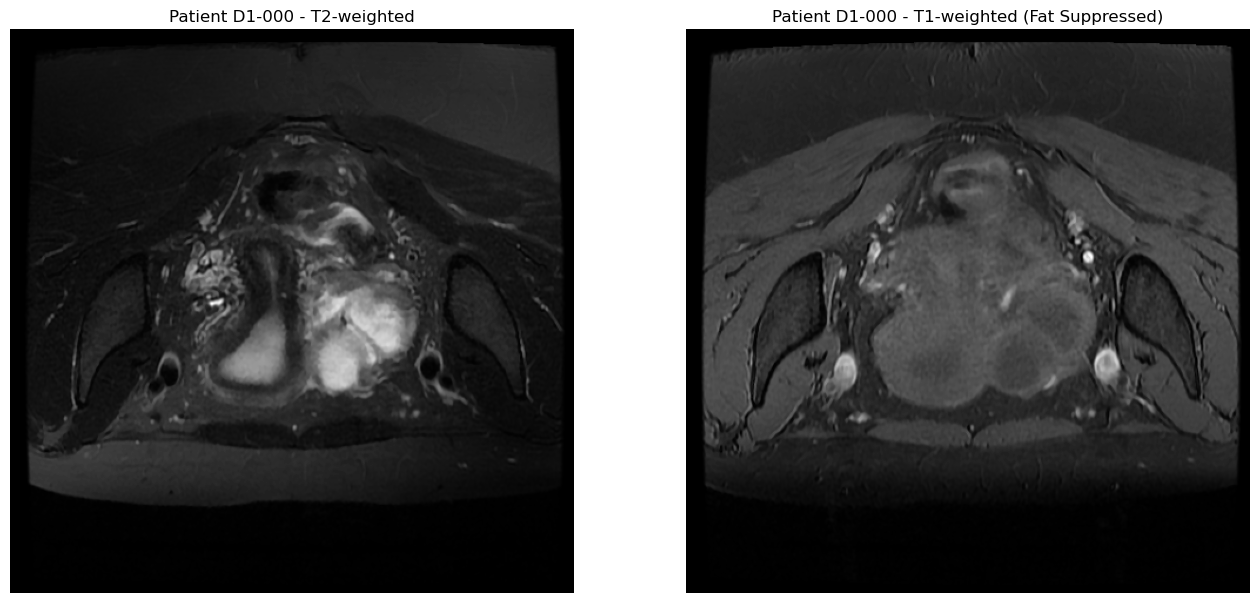

In [4]:
# Cell 3: Compare MRI Modalities for Patient D1-000

patient_id = 'D1-000'
patient_path = os.path.join(data_root, 'D1_MHS', patient_id)

# Paths for T2 and T1 Fat-Suppressed scans
t2_path = os.path.join(patient_path, f'{patient_id}_T2.nii.gz')
t1fs_path = os.path.join(patient_path, f'{patient_id}_T1FS.nii.gz')

# Load images
t2_image = sitk.ReadImage(t2_path)
t1fs_image = sitk.ReadImage(t1fs_path)

# Convert to NumPy arrays
t2_array = sitk.GetArrayFromImage(t2_image)
t1fs_array = sitk.GetArrayFromImage(t1fs_image)

# Get the same middle slice
slice_index = t2_array.shape[0] // 2
t2_slice = t2_array[slice_index, :, :]
t1fs_slice = t1fs_array[slice_index, :, :]

# Display side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(t2_slice, cmap='gray')
ax1.set_title(f'Patient {patient_id} - T2-weighted')
ax1.axis('off')

ax2.imshow(t1fs_slice, cmap='gray')
ax2.set_title(f'Patient {patient_id} - T1-weighted (Fat Suppressed)')
ax2.axis('off')

plt.show()

MRI Modalities

MRI isn't just one type of scan. By changing the settings on the machine, doctors can highlight different types of tissue. These different "settings" are called modalities or sequences. The most common are T1-weighted and T2-weighted.

    T2-weighted (T2): In these scans, water and fluid appear bright. This is great for spotting things like cysts or inflammation.

    T1-weighted (T1): In these, fat appears bright, which is good for seeing the general anatomy.

    Fat Suppressed (FS): This is an extra trick applied to a T1 or T2 scan to make the fat tissue appear dark. This can make it easier to see abnormal tissues that might otherwise be hidden.

Analogy: Think of MRI modalities like different filters on your phone's camera. A "black and white" filter highlights shapes and contrast, while a "vivid color" filter makes certain features pop. Doctors use different MRI modalities to "filter" the image to see specific tissues more clearly.

We only displayed two modalities to keep the example simple, but a patient folder can contain several.

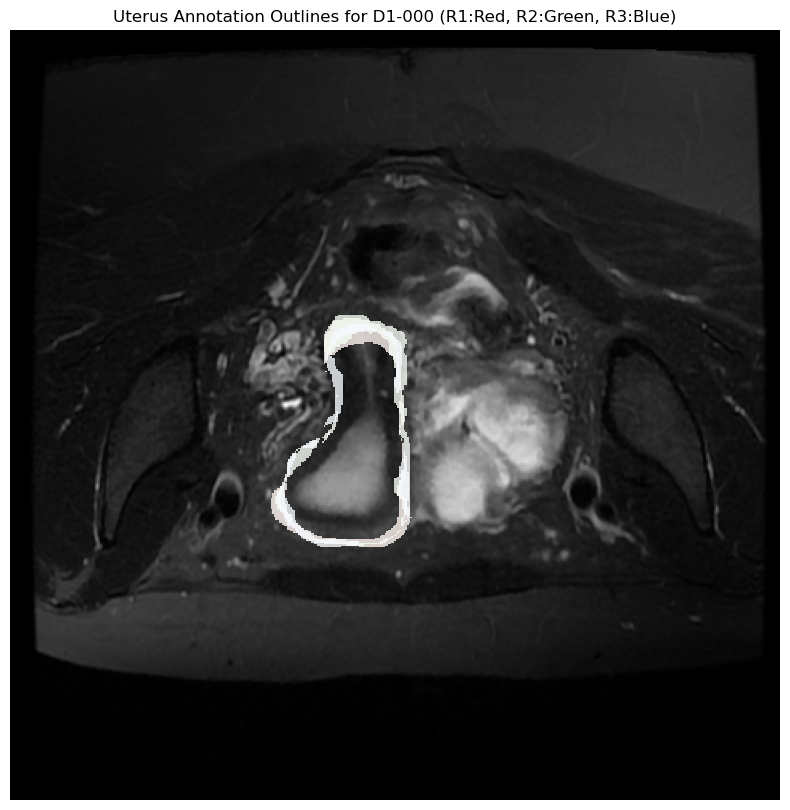

In [5]:
# Cell 4 (Corrected Version): Compare Rater Annotations for Patient D1-000

# Paths to the three rater masks for the uterus
mask_r1_path = os.path.join(patient_path, f'{patient_id}_ut_r1.nii.gz')
mask_r2_path = os.path.join(patient_path, f'{patient_id}_ut_r2.nii.gz')
mask_r3_path = os.path.join(patient_path, f'{patient_id}_ut_r3.nii.gz')

# Load masks
mask_r1_img = sitk.ReadImage(mask_r1_path)
mask_r2_img = sitk.ReadImage(mask_r2_path)
mask_r3_img = sitk.ReadImage(mask_r3_path)

# --- FIX IS HERE ---
# Cast images to an integer type before finding the contour
caster = sitk.CastImageFilter()
caster.SetOutputPixelType(sitk.sitkUInt8)
mask_r1_img = caster.Execute(mask_r1_img)
mask_r2_img = caster.Execute(mask_r2_img)
mask_r3_img = caster.Execute(mask_r3_img)
# --- END FIX ---

# Get the contour (outline) of each mask
contour_r1 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r1_img, fullyConnected=True))[slice_index, :, :]
contour_r2 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r2_img, fullyConnected=True))[slice_index, :, :]
contour_r3 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r3_img, fullyConnected=True))[slice_index, :, :]

# Mask the contours for transparent overlay
masked_contour_r1 = np.ma.masked_where(contour_r1 == 0, contour_r1)
masked_contour_r2 = np.ma.masked_where(contour_r2 == 0, contour_r2)
masked_contour_r3 = np.ma.masked_where(contour_r3 == 0, contour_r3)

# Display the overlays on the T2 image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(t2_slice, cmap='gray')
ax.imshow(masked_contour_r1, cmap='Reds', alpha=0.8)
ax.imshow(masked_contour_r2, cmap='Greens', alpha=0.8)
ax.imshow(masked_contour_r3, cmap='Blues', alpha=0.8)
ax.set_title(f'Uterus Annotation Outlines for {patient_id} (R1:Red, R2:Green, R3:Blue)')
ax.axis('off')
plt.show()

Raters and Annotations

Raters are the human experts (like radiologists) who manually created the ground truth segmentations. They looked at the MRI scans and "painted" the regions corresponding to the different organs.

How annotations are stored: The segmentation is not a list of coordinates. It's actually a separate image file with the exact same dimensions as the MRI scan. In this mask image, every pixel has a value. For example, a pixel value of 1 means "this pixel is part of the uterus," and a pixel value of 0 means "this is not part of the uterus."

Analogy: It's like taking a photograph (the MRI) and placing a clear plastic sheet over it. You then use a red marker to carefully trace and color in the uterus. That plastic sheet is the segmentation mask. Our model's job is to learn how to create that red coloring automatically.

In [6]:
# Cell 5: Inspect Image Metadata

# We already loaded t2_image
image_size = t2_image.GetSize()
voxel_spacing = t2_image.GetSpacing()
origin = t2_image.GetOrigin()
direction = t2_image.GetDirection()

print(f"--- Metadata for {patient_id} T2 Scan ---")
print(f"Image Dimensions (width, height, depth): {image_size}")
print(f"Voxel Spacing (mm): {tuple(round(s, 2) for s in voxel_spacing)}")
print(f"Origin (mm): {tuple(round(o, 2) for o in origin)}")
print(f"Direction Cosine Matrix: {tuple(round(d, 2) for d in direction)}")

--- Metadata for D1-000 T2 Scan ---
Image Dimensions (width, height, depth): (480, 480, 32)
Voxel Spacing (mm): (0.5, 0.5, 5.0)
Origin (mm): (-139.6, 133.0, -20.26)
Direction Cosine Matrix: (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


Image Metadata Explained

    Image Dimensions (480, 480, 32): An MRI is a 3D image. Think of a loaf of bread. The 480x480 is the resolution (width and height) of a single slice, and 32 is the number of slices in the loaf (the depth). Not all images will have these exact dimensions.

    Voxel Spacing (0.5, 0.5, 5.0): This is the real-world size of a single 3D pixel (a "voxel") in millimeters. This scan's voxels are 0.5mm wide, 0.5mm high, but 5.0mm thick. This tells us the resolution is much higher within a slice than between slices. This is very important for preprocessing.

    Origin & Direction Cosine Matrix: These two parameters place the image in a physical 3D coordinate system relative to the MRI machine. The Origin is the (x, y, z) coordinate of the corner of the first voxel. The Direction matrix defines the orientation of the image grid (e.g., which way is left/right, up/down). For our purposes, our tools will handle this, but it's what allows medical software to know the exact position and orientation of the scan relative to the patient's body.

In [8]:
import pandas as pd

# Define the path to the D2_TCPW dataset
d2_path = '../data/UT-EndoMRI/D2_TCPW'

# Get a sorted list of all patient directories
try:
    patient_dirs = sorted([d for d in os.listdir(d2_path) if os.path.isdir(os.path.join(d2_path, d))])
except FileNotFoundError:
    print(f"Error: The directory '{d2_path}' was not found. Make sure your data is extracted correctly.")
    # Stop execution if the directory doesn't exist
    raise

# This list will store the information for our manifest
manifest_data = []

# Loop through each patient directory
for patient_id in patient_dirs:
    patient_folder = os.path.join(d2_path, patient_id)
    
    # Define the expected filenames for the T2 MRI and the uterus mask
    t2_filename = f'{patient_id}_T2.nii.gz'
    ut_mask_filename = f'{patient_id}_ut.nii.gz'
    
    t2_filepath = os.path.join(patient_folder, t2_filename)
    ut_mask_filepath = os.path.join(patient_folder, ut_mask_filename)
    
    # Check if both the T2 scan and the uterus mask exist for this patient
    if os.path.exists(t2_filepath) and os.path.exists(ut_mask_filepath):
        # If they exist, add them to our list
        manifest_data.append({
            'patient_id': patient_id,
            'mri_path': t2_filepath,
            'mask_path': ut_mask_filepath
        })
    else:
        # Print a warning if a patient is missing one of the required files
        print(f"Skipping {patient_id}: Missing T2 scan or uterus mask.")

# Convert the list of data into a pandas DataFrame
manifest_df = pd.DataFrame(manifest_data)

# Define the output path for our CSV file
output_path = '../data/d2_manifest.csv'
manifest_df.to_csv(output_path, index=False)

# Print the first 5 rows of the DataFrame to verify it looks correct
print(f"\nSuccessfully created manifest at: {output_path}")
print(f"Found data for {len(manifest_df)} patients.")
print("\nManifest preview:")
print(manifest_df.head())

Skipping D2-014: Missing T2 scan or uterus mask.
Skipping D2-016: Missing T2 scan or uterus mask.
Skipping D2-017: Missing T2 scan or uterus mask.
Skipping D2-018: Missing T2 scan or uterus mask.
Skipping D2-019: Missing T2 scan or uterus mask.
Skipping D2-021: Missing T2 scan or uterus mask.
Skipping D2-022: Missing T2 scan or uterus mask.
Skipping D2-023: Missing T2 scan or uterus mask.
Skipping D2-025: Missing T2 scan or uterus mask.
Skipping D2-026: Missing T2 scan or uterus mask.
Skipping D2-027: Missing T2 scan or uterus mask.
Skipping D2-028: Missing T2 scan or uterus mask.
Skipping D2-029: Missing T2 scan or uterus mask.
Skipping D2-038: Missing T2 scan or uterus mask.
Skipping D2-041: Missing T2 scan or uterus mask.
Skipping D2-046: Missing T2 scan or uterus mask.
Skipping D2-049: Missing T2 scan or uterus mask.
Skipping D2-052: Missing T2 scan or uterus mask.
Skipping D2-054: Missing T2 scan or uterus mask.
Skipping D2-057: Missing T2 scan or uterus mask.
Skipping D2-061: Mis

In [9]:
# Cell to create a manifest for the T2FS dataset

# Define the path to the D2_TCPW dataset
d2_path = '../data/UT-EndoMRI/D2_TCPW'

# Get a sorted list of all patient directories
patient_dirs = sorted([d for d in os.listdir(d2_path) if os.path.isdir(os.path.join(d2_path, d))])

manifest_data_t2fs = []

# Loop through each patient directory
for patient_id in patient_dirs:
    patient_folder = os.path.join(d2_path, patient_id)
    
    # --- CHANGE IS HERE ---
    # We are now looking for the T2FS file instead of the T2 file
    t2fs_filename = f'{patient_id}_T2FS.nii.gz'
    ut_mask_filename = f'{patient_id}_ut.nii.gz'
    
    t2fs_filepath = os.path.join(patient_folder, t2fs_filename)
    ut_mask_filepath = os.path.join(patient_folder, ut_mask_filename)
    
    # Check if both the T2FS scan and the uterus mask exist
    if os.path.exists(t2fs_filepath) and os.path.exists(ut_mask_filepath):
        manifest_data_t2fs.append({
            'patient_id': patient_id,
            'mri_path': t2fs_filepath,
            'mask_path': ut_mask_filepath
        })
    else:
        print(f"Skipping {patient_id}: Missing T2FS scan or uterus mask.")

# Convert the list to a DataFrame
manifest_t2fs_df = pd.DataFrame(manifest_data_t2fs)

# Save to a new CSV file
output_t2fs_path = '../data/d2_manifest_t2fs.csv'
manifest_t2fs_df.to_csv(output_t2fs_path, index=False)

print(f"\nSuccessfully created T2FS manifest at: {output_t2fs_path}")
print(f"Found data for {len(manifest_t2fs_df)} patients using T2FS.")
print("\nT2FS Manifest preview:")
print(manifest_t2fs_df.head())

Skipping D2-041: Missing T2FS scan or uterus mask.
Skipping D2-046: Missing T2FS scan or uterus mask.
Skipping D2-052: Missing T2FS scan or uterus mask.
Skipping D2-054: Missing T2FS scan or uterus mask.
Skipping D2-057: Missing T2FS scan or uterus mask.
Skipping D2-063: Missing T2FS scan or uterus mask.
Skipping D2-068: Missing T2FS scan or uterus mask.
Skipping D2-069: Missing T2FS scan or uterus mask.
Skipping D2-070: Missing T2FS scan or uterus mask.
Skipping D2-071: Missing T2FS scan or uterus mask.
Skipping D2-074: Missing T2FS scan or uterus mask.
Skipping D2-076: Missing T2FS scan or uterus mask.
Skipping D2-077: Missing T2FS scan or uterus mask.

Successfully created T2FS manifest at: ../data/d2_manifest_t2fs.csv
Found data for 60 patients using T2FS.

T2FS Manifest preview:
  patient_id                                           mri_path  \
0     D2-000  ../data/UT-EndoMRI/D2_TCPW\D2-000\D2-000_T2FS....   
1     D2-001  ../data/UT-EndoMRI/D2_TCPW\D2-001\D2-001_T2FS....   
2   

Why are we only using the D2 dataset?

This is a strategic choice that comes down to one key principle in machine learning: controlling variables. To run a good experiment, you want to change only one thing at a time. The D1 and D2 datasets have two major differences that would complicate our project.

Consistent Scanning: The D2 dataset was collected at a single hospital with a single type of MRI machine. This means all the images have very similar properties (noise, contrast, resolution, etc.). The D1 dataset, on the other hand, was collected from 15 different sites using 9 different scanner models.

Analogy: Imagine you're training a model to recognize apples. The D2 dataset is like getting 1000 photos of apples all taken with the same iPhone in the same room with the same lighting. The D1 dataset is like getting 1000 photos of apples from the internet, taken with everything from professional cameras to old flip phones. By using only the D2 "iPhone" photos, we can be sure our model is learning to recognize apples, not just learning to deal with weird lighting or blurry images.

Consistent Annotations: The D2 dataset was annotated by a single expert. This means the "style" of drawing the segmentation boundaries is consistent across all 60 patients. The D1 dataset was annotated by three different experts. As we saw with our outline plot, they mostly agree, but there are small differences.

    __init__: What to do when the dataset is first created (e.g., load our manifest file).

    __len__: How many total items are in the dataset.

    __getitem__: How to get a single item (one image and its mask) given its index number.

Our main challenge is that our data is stored as 3D volumes, but we want to train our model on 2D slices. Our Dataset class will handle this conversion. It will create a master list of every single 2D slice from every patient, so that __getitem__ can simply fetch one slice at a time.

Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.

Total number of usable slices: 582
Shape of image tensor: torch.Size([1, 352, 352])
Shape of mask tensor: torch.Size([1, 352, 352])


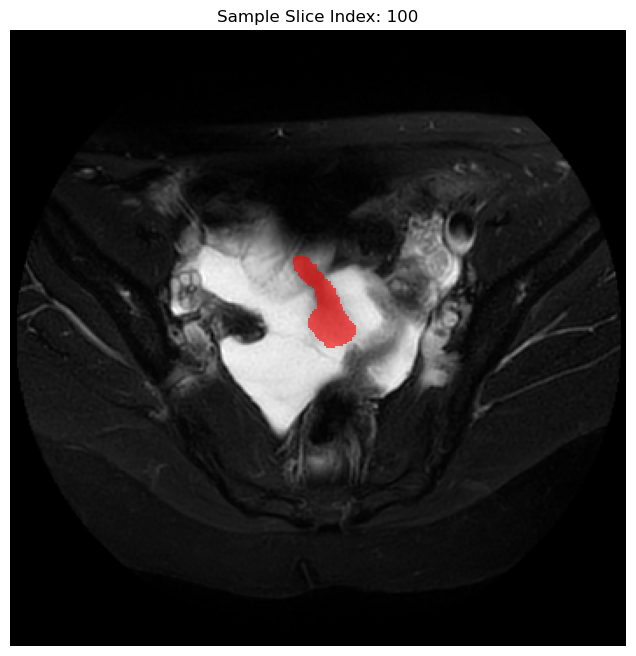

In [11]:
import torch
from torch.utils.data import Dataset

class UterusDataset(Dataset):
    """
    PyTorch Dataset for loading 2D slices from 3D MRI scans of the uterus.
    """
    def __init__(self, manifest_path):
        """
        Args:
            manifest_path (str): Path to the manifest CSV file.
        """
        self.manifest = pd.read_csv(manifest_path)
        self.slice_map = []
        
        print("Loading dataset and creating slice map...")
        # This loop creates a map of every slice from every patient
        for patient_index, row in self.manifest.iterrows():
            # We'll get the number of slices from the mask file's metadata
            mask_image = sitk.ReadImage(row['mask_path'])
            num_slices = mask_image.GetSize()[2] # Get depth/number of slices
            
            for slice_index in range(num_slices):
                # We only want to train on slices that actually contain the uterus
                # To check this, we load the 3D mask and see if the slice has any non-zero pixels
                mask_array = sitk.GetArrayFromImage(mask_image)
                if np.sum(mask_array[slice_index, :, :]) > 0:
                    self.slice_map.append({
                        'patient_index': patient_index,
                        'slice_index': slice_index
                    })
        print(f"Slice map created. Found {len(self.slice_map)} slices containing the uterus.")

    def __len__(self):
        """
        Returns the total number of slices in the dataset.
        """
        return len(self.slice_map)

    def __getitem__(self, idx):
        """
        Fetches a single 2D slice and its corresponding mask.
        
        Args:
            idx (int): Index of the slice to fetch from the slice_map.
            
        Returns:
            tuple: (image_tensor, mask_tensor)
        """
        # Get the patient and slice info for this index
        slice_info = self.slice_map[idx]
        patient_index = slice_info['patient_index']
        slice_index = slice_info['slice_index']
        
        # Get the file paths from the manifest
        patient_data = self.manifest.iloc[patient_index]
        mri_path = patient_data['mri_path']
        mask_path = patient_data['mask_path']
        
        # Load the 3D images
        mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
        mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8)
        
        # Convert to NumPy arrays
        mri_array = sitk.GetArrayFromImage(mri_image)
        mask_array = sitk.GetArrayFromImage(mask_image)
        
        # Get the specific 2D slice
        mri_slice = mri_array[slice_index, :, :]
        mask_slice = mask_array[slice_index, :, :]
        
        # Convert NumPy arrays to PyTorch tensors
        # We need to add a "channel" dimension for the model (C, H, W)
        image_tensor = torch.from_numpy(mri_slice).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_slice).unsqueeze(0)
        
        return image_tensor, mask_tensor

# --- Test the Dataset Class ---

# Instantiate the dataset using our T2FS manifest
manifest_path = '../data/d2_manifest_t2fs.csv'
uterus_dataset = UterusDataset(manifest_path=manifest_path)

# Check the total number of slices
print(f"\nTotal number of usable slices: {len(uterus_dataset)}")

# Get a sample from the dataset (e.g., the 100th slice)
sample_idx = 100
image_tensor, mask_tensor = uterus_dataset[sample_idx]

# Print the shapes to verify they are correct
print(f"Shape of image tensor: {image_tensor.shape}")
print(f"Shape of mask tensor: {mask_tensor.shape}")

# Visualize the sample to confirm it loaded correctly
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image_tensor.squeeze(), cmap='gray') # .squeeze() removes the channel dimension for plotting
masked_sample = np.ma.masked_where(mask_tensor.squeeze() == 0, mask_tensor.squeeze())
ax.imshow(masked_sample, cmap='autumn', alpha=0.6)
ax.set_title(f'Sample Slice Index: {sample_idx}')
ax.axis('off')
plt.show()

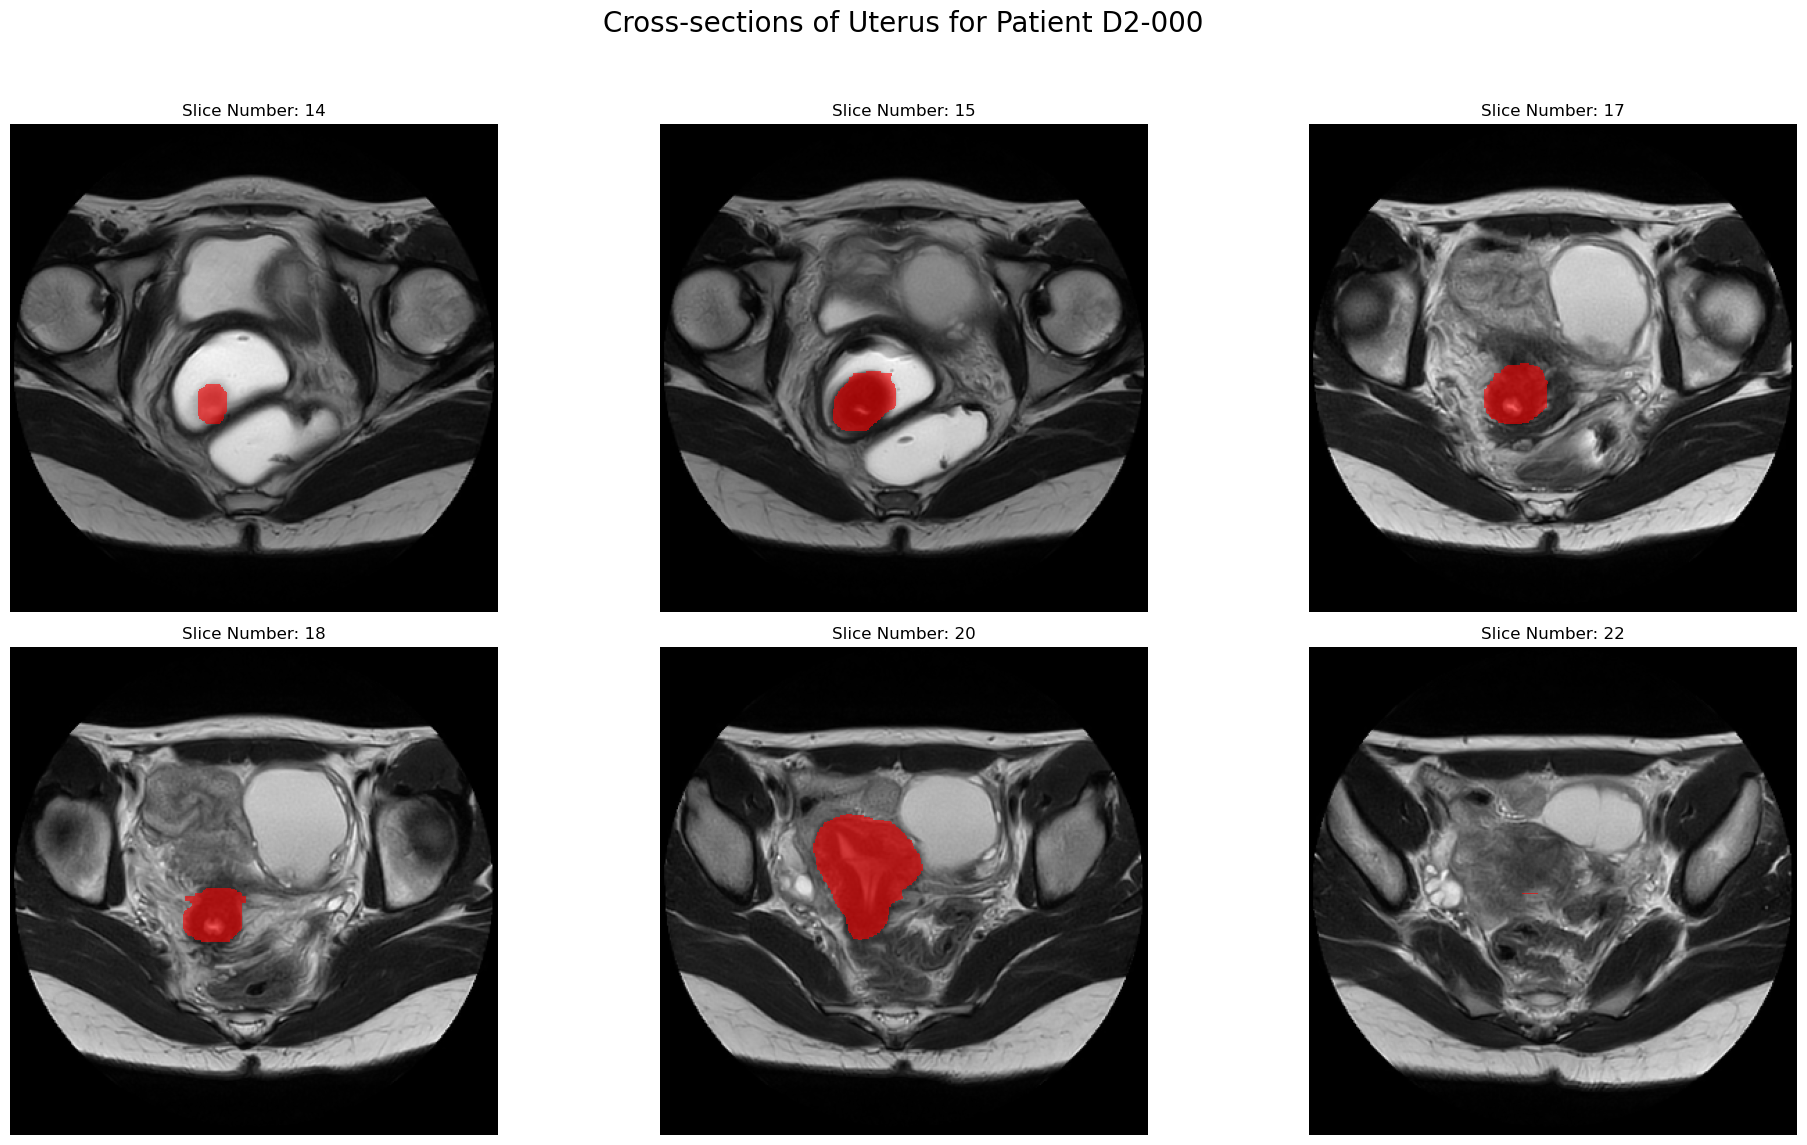

In [12]:
# --- Visualize Multiple Slices from a Single Patient ---

# Get the data for the first patient in our manifest
first_patient_data = manifest_df.iloc[0]
mri_path = first_patient_data['mri_path']
mask_path = first_patient_data['mask_path']

# Load the full 3D volumes
mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8)

mri_array = sitk.GetArrayFromImage(mri_image)
mask_array = sitk.GetArrayFromImage(mask_image)

# Find all slices that contain the uterus mask
uterus_slice_indices = np.where(np.sum(mask_array, axis=(1, 2)) > 0)[0]

# Select 6 evenly spaced slices to display
num_slices_to_show = 6
selected_indices = np.linspace(0, len(uterus_slice_indices) - 1, num_slices_to_show, dtype=int)
slice_numbers_to_show = uterus_slice_indices[selected_indices]

# Create a plot to display the slices
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten() # Flatten the 2x3 grid into a 1D array for easy looping

for i, slice_num in enumerate(slice_numbers_to_show):
    mri_slice = mri_array[slice_num, :, :]
    mask_slice = mask_array[slice_num, :, :]
    
    masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
    
    axes[i].imshow(mri_slice, cmap='gray')
    axes[i].imshow(masked_overlay, cmap='autumn', alpha=0.6)
    axes[i].set_title(f'Slice Number: {slice_num}')
    axes[i].axis('off')

plt.suptitle(f'Cross-sections of Uterus for Patient {first_patient_data["patient_id"]}', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

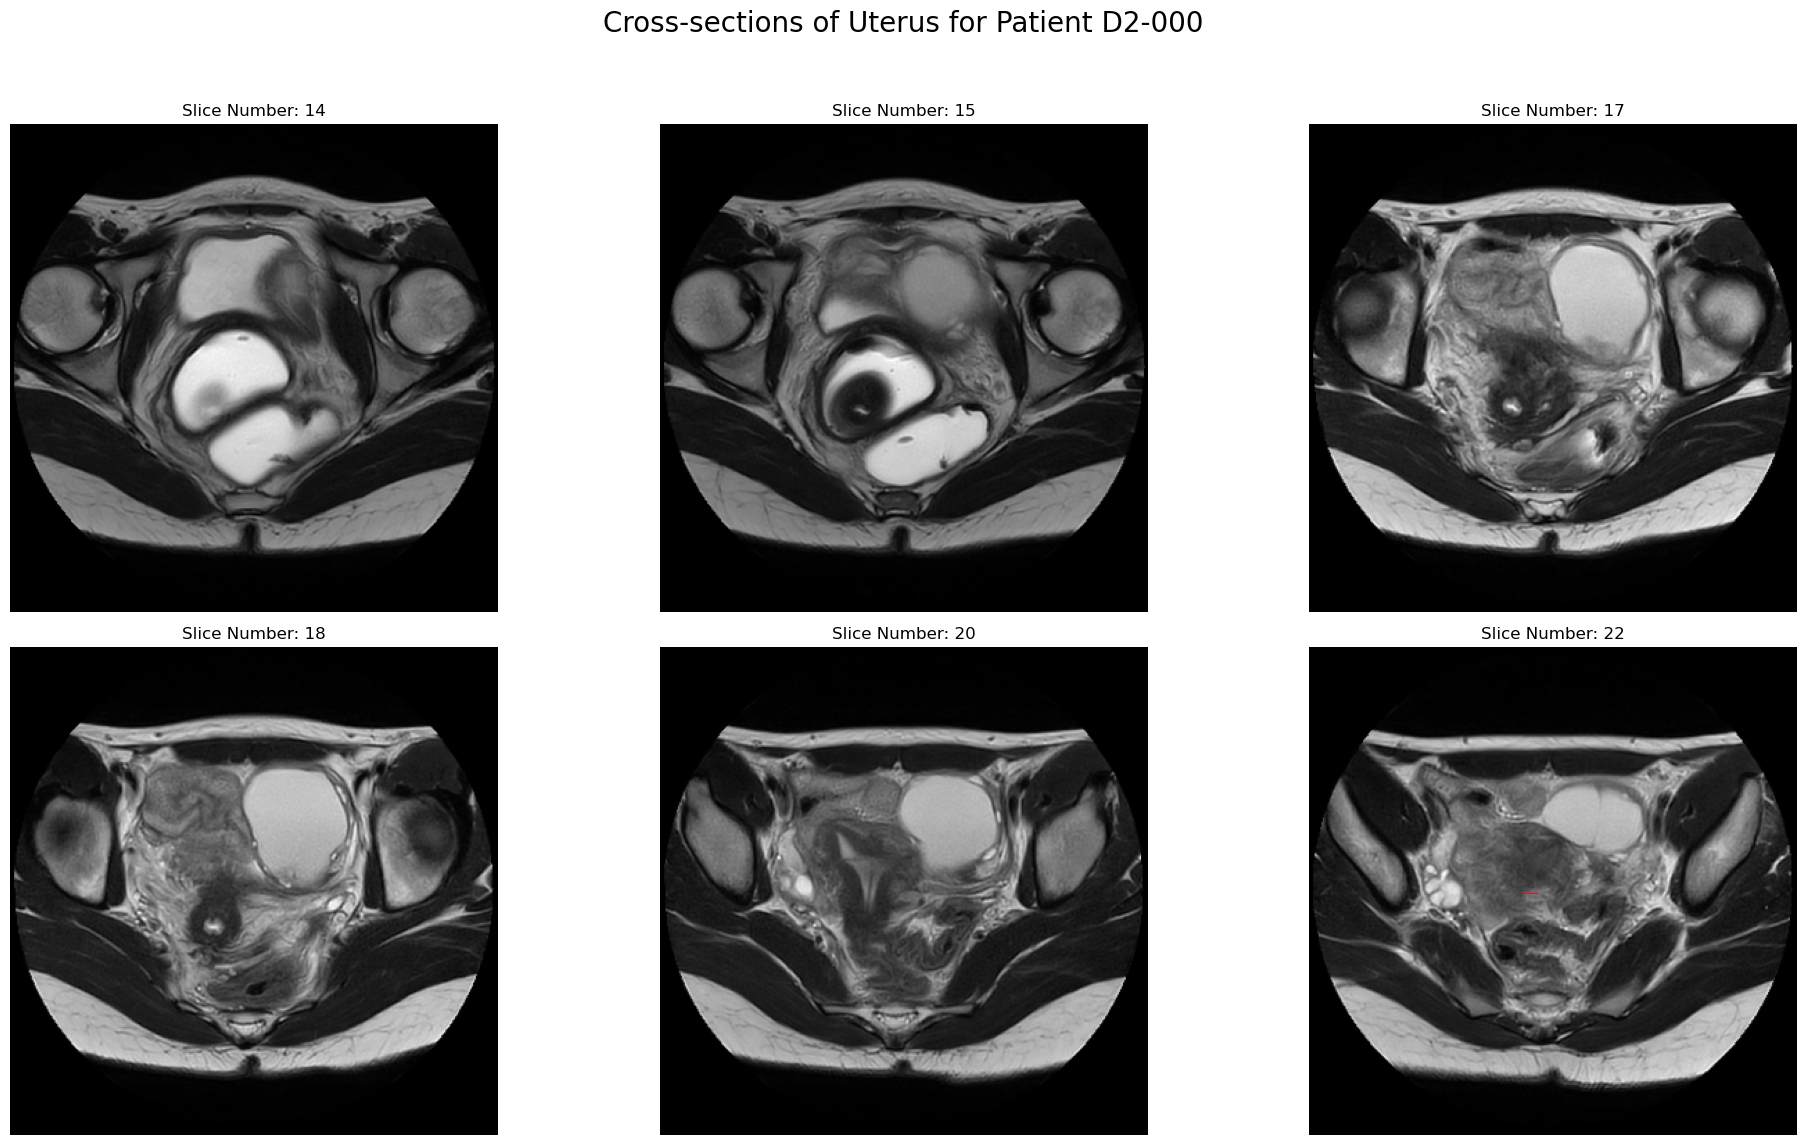

In [13]:
# --- Visualize Multiple Slices with CONTOURS from a Single Patient ---

# Get the data for the first patient in our manifest
first_patient_data = manifest_df.iloc[0]
mri_path = first_patient_data['mri_path']
mask_path = first_patient_data['mask_path']

# Load the full 3D volumes
mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8) # Already UInt8, good.

mri_array = sitk.GetArrayFromImage(mri_image)
mask_array = sitk.GetArrayFromImage(mask_image)

# Find all slices that contain the uterus mask
uterus_slice_indices = np.where(np.sum(mask_array, axis=(1, 2)) > 0)[0]

# Select 6 evenly spaced slices to display
num_slices_to_show = 6
selected_indices = np.linspace(0, len(uterus_slice_indices) - 1, num_slices_to_show, dtype=int)
slice_numbers_to_show = uterus_slice_indices[selected_indices]

# Create a plot to display the slices
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, slice_num in enumerate(slice_numbers_to_show):
    mri_slice = mri_array[slice_num, :, :]
    mask_slice_np = mask_array[slice_num, :, :]
    
    # --- CHANGE IS HERE ---
    # Convert the NumPy slice back to a SimpleITK image to find its contour
    mask_slice_sitk = sitk.GetImageFromArray(mask_slice_np)
    contour_img = sitk.BinaryContour(mask_slice_sitk, fullyConnected=True)
    contour_np = sitk.GetArrayFromImage(contour_img)
    # --- END CHANGE ---

    masked_overlay = np.ma.masked_where(contour_np == 0, contour_np)
    
    axes[i].imshow(mri_slice, cmap='gray')
    axes[i].imshow(masked_overlay, cmap='autumn', alpha=0.8) # Using alpha=0.8 for a solid line
    axes[i].set_title(f'Slice Number: {slice_num}')
    axes[i].axis('off')

plt.suptitle(f'Cross-sections of Uterus for Patient {first_patient_data["patient_id"]}', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

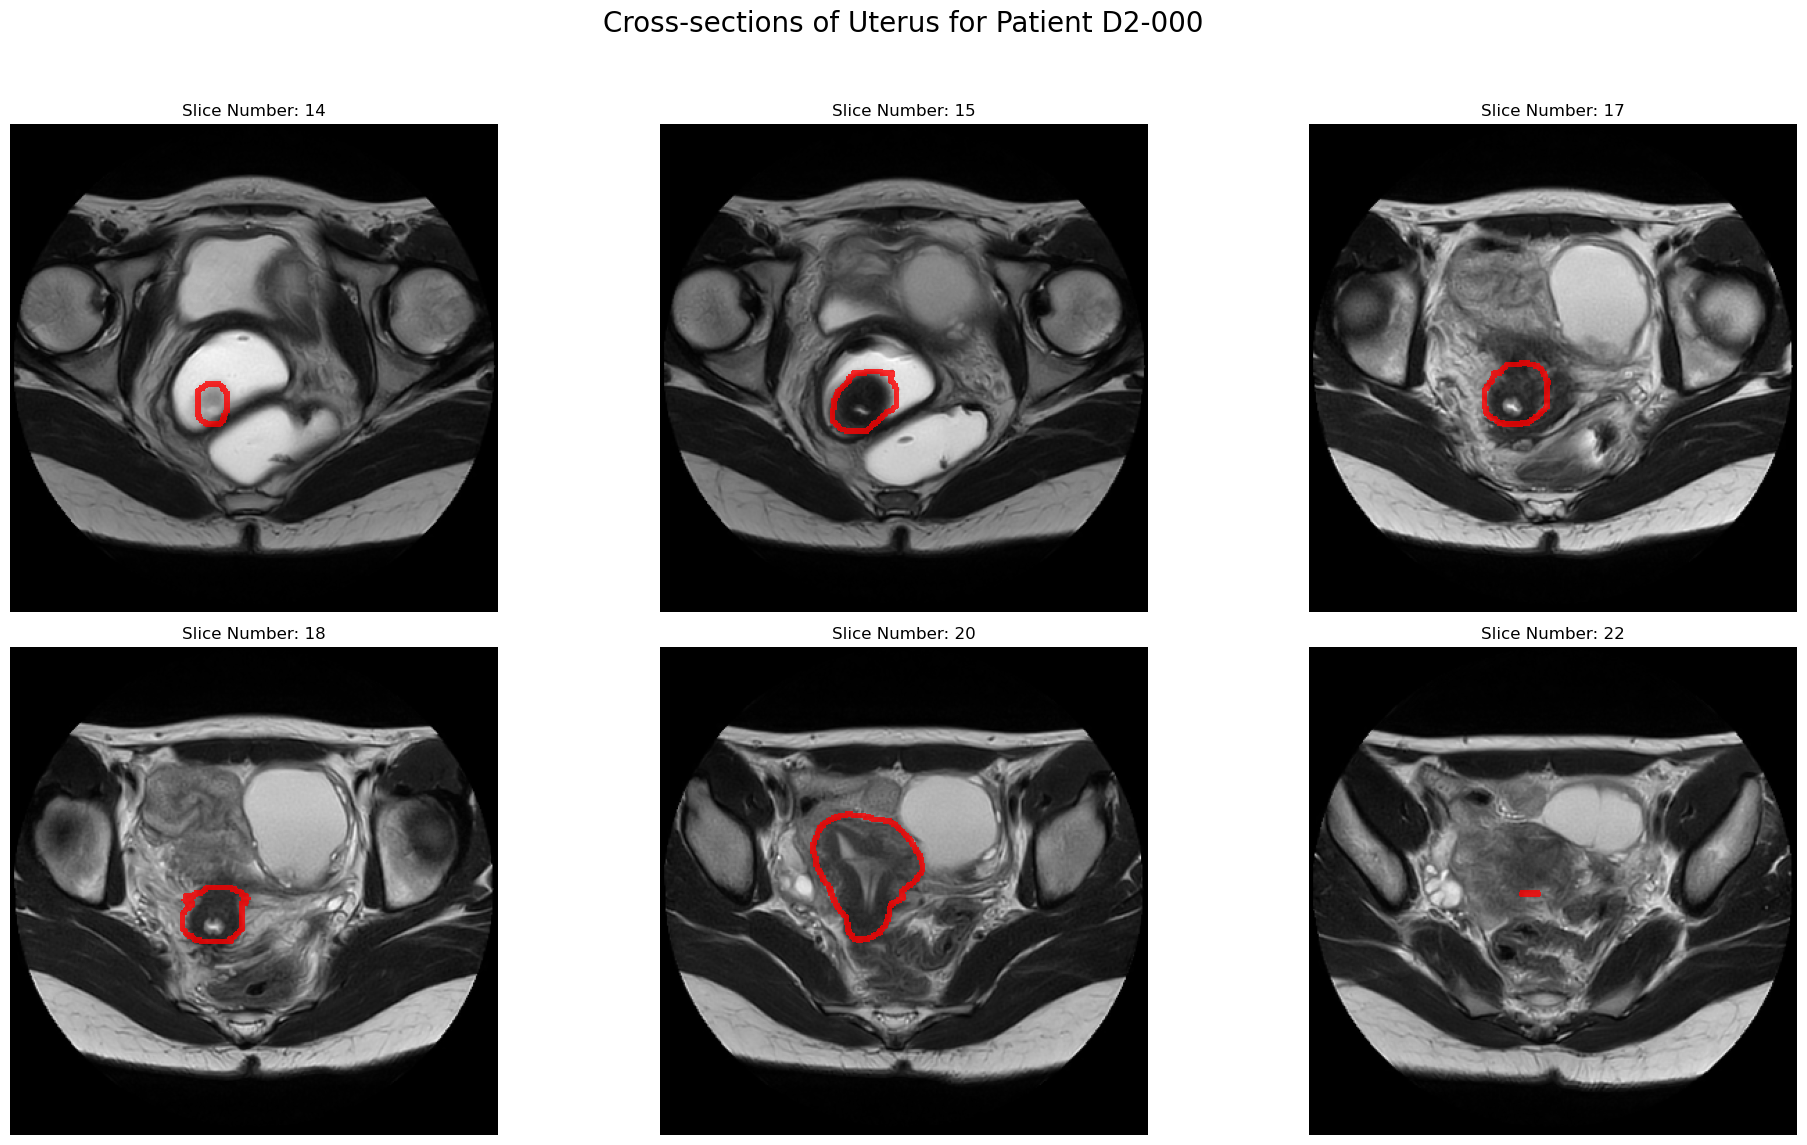

In [14]:
# --- Visualize Multiple Slices with THICK CONTOURS from a Single Patient ---

# Get the data for the first patient in our manifest
first_patient_data = manifest_df.iloc[0]
mri_path = first_patient_data['mri_path']
mask_path = first_patient_data['mask_path']

# Load the full 3D volumes
mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8)

mri_array = sitk.GetArrayFromImage(mri_image)
mask_array = sitk.GetArrayFromImage(mask_image)

# Find all slices that contain the uterus mask
uterus_slice_indices = np.where(np.sum(mask_array, axis=(1, 2)) > 0)[0]

# Select 6 evenly spaced slices to display
num_slices_to_show = 6
selected_indices = np.linspace(0, len(uterus_slice_indices) - 1, num_slices_to_show, dtype=int)
slice_numbers_to_show = uterus_slice_indices[selected_indices]

# Create a plot to display the slices
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# --- NEW: Create a dilation filter once ---
dilate_filter = sitk.BinaryDilateImageFilter()
dilate_filter.SetKernelRadius(2) # This will create a nice thick line

for i, slice_num in enumerate(slice_numbers_to_show):
    mri_slice = mri_array[slice_num, :, :]
    mask_slice_np = mask_array[slice_num, :, :]
    
    # Convert the NumPy slice back to a SimpleITK image to find its contour
    mask_slice_sitk = sitk.GetImageFromArray(mask_slice_np)
    contour_img = sitk.BinaryContour(mask_slice_sitk, fullyConnected=True)
    
    # --- FIX IS HERE ---
    # Dilate the contour to make it thicker and more visible
    thick_contour_img = dilate_filter.Execute(contour_img)
    contour_np = sitk.GetArrayFromImage(thick_contour_img)
    # --- END FIX ---

    masked_overlay = np.ma.masked_where(contour_np == 0, contour_np)
    
    axes[i].imshow(mri_slice, cmap='gray')
    axes[i].imshow(masked_overlay, cmap='autumn', alpha=0.8)
    axes[i].set_title(f'Slice Number: {slice_num}')
    axes[i].axis('off')

plt.suptitle(f'Cross-sections of Uterus for Patient {first_patient_data["patient_id"]}', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.

Total number of usable slices: 582
Shape of transformed image tensor: torch.Size([1, 256, 256])
Shape of transformed mask tensor: torch.Size([1, 256, 256])
Image tensor value range: [0.00, 1.00]


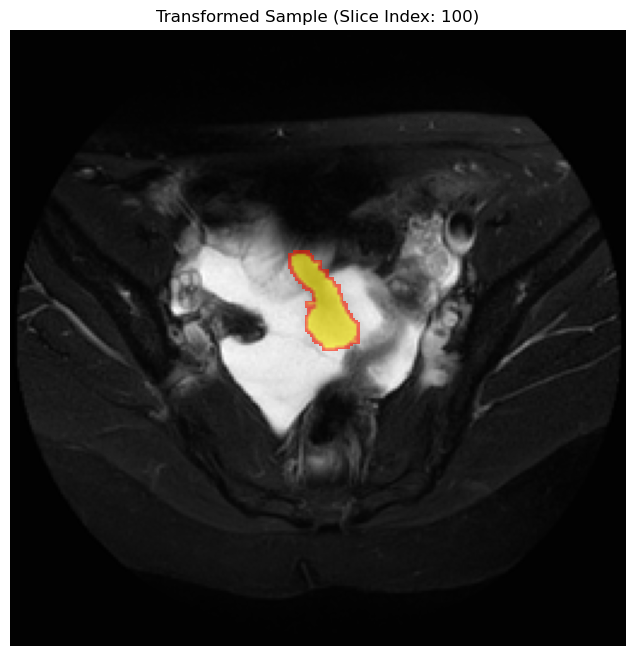

In [16]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class UterusDataset(Dataset):
    """
    PyTorch Dataset for loading 2D slices from 3D MRI scans of the uterus.
    Now includes preprocessing transforms.
    """
    def __init__(self, manifest_path, transforms=None):
        """
        Args:
            manifest_path (str): Path to the manifest CSV file.
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.manifest = pd.read_csv(manifest_path)
        self.transforms = transforms
        self.slice_map = []
        
        print("Loading dataset and creating slice map...")
        for patient_index, row in self.manifest.iterrows():
            mask_image = sitk.ReadImage(row['mask_path'])
            num_slices = mask_image.GetSize()[2]
            
            for slice_index in range(num_slices):
                # We are pre-filtering to only include slices with the uterus.
                # This is efficient for small datasets.
                mask_array = sitk.GetArrayFromImage(mask_image)
                if np.sum(mask_array[slice_index, :, :]) > 0:
                    self.slice_map.append({
                        'patient_index': patient_index,
                        'slice_index': slice_index
                    })
        print(f"Slice map created. Found {len(self.slice_map)} slices containing the uterus.")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        slice_info = self.slice_map[idx]
        patient_index = slice_info['patient_index']
        slice_index = slice_info['slice_index']
        
        patient_data = self.manifest.iloc[patient_index]
        mri_path = patient_data['mri_path']
        mask_path = patient_data['mask_path']
        
        # Load the 3D images as float32 for MRI and uint8 for mask
        mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
        mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8)
        
        mri_array = sitk.GetArrayFromImage(mri_image)
        mask_array = sitk.GetArrayFromImage(mask_image)
        
        mri_slice = mri_array[slice_index, :, :]
        mask_slice = mask_array[slice_index, :, :]
        
        # Convert to PyTorch Tensors and add channel dimension
        image_tensor = torch.from_numpy(mri_slice).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_slice).unsqueeze(0).float() # Also convert mask to float for transforms
        
        # Apply transforms if they exist
        if self.transforms:
            # We need to apply the same transform to both image and mask
            # To do this, we concatenate them, transform, then split them back.
            combined = torch.cat([image_tensor, mask_tensor], dim=0)
            combined_transformed = self.transforms(combined)
            image_tensor = combined_transformed[0, :, :].unsqueeze(0)
            mask_tensor = combined_transformed[1, :, :].unsqueeze(0)

        # Normalize the image tensor to [0, 1] range
        min_val = image_tensor.min()
        max_val = image_tensor.max()
        if max_val > min_val:
            image_tensor = (image_tensor - min_val) / (max_val - min_val)

        return image_tensor, mask_tensor

# --- Test the Updated Dataset Class with Transforms ---

# Define the transformations: resize to 256x256
# We use 'antialias=True' for better image quality when resizing.
# Interpolation mode BICUBIC for the image, and NEAREST for the mask to keep sharp edges.
data_transforms = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC, antialias=True)
])

# Instantiate the dataset with the transforms
manifest_path = '../data/d2_manifest_t2fs.csv'
uterus_dataset_transformed = UterusDataset(manifest_path=manifest_path, transforms=data_transforms)

# Check the total number of slices
print(f"\nTotal number of usable slices: {len(uterus_dataset_transformed)}")

# Get a sample and check its shape
sample_idx = 100
image_tensor, mask_tensor = uterus_dataset_transformed[sample_idx]

print(f"Shape of transformed image tensor: {image_tensor.shape}")
print(f"Shape of transformed mask tensor: {mask_tensor.shape}")
print(f"Image tensor value range: [{image_tensor.min():.2f}, {image_tensor.max():.2f}]")


# Visualize the transformed sample
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image_tensor.squeeze(), cmap='gray')
masked_sample = np.ma.masked_where(mask_tensor.squeeze() == 0, mask_tensor.squeeze())
ax.imshow(masked_sample, cmap='autumn', alpha=0.6)
ax.set_title(f'Transformed Sample (Slice Index: {sample_idx})')
ax.axis('off')
plt.show()

Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.


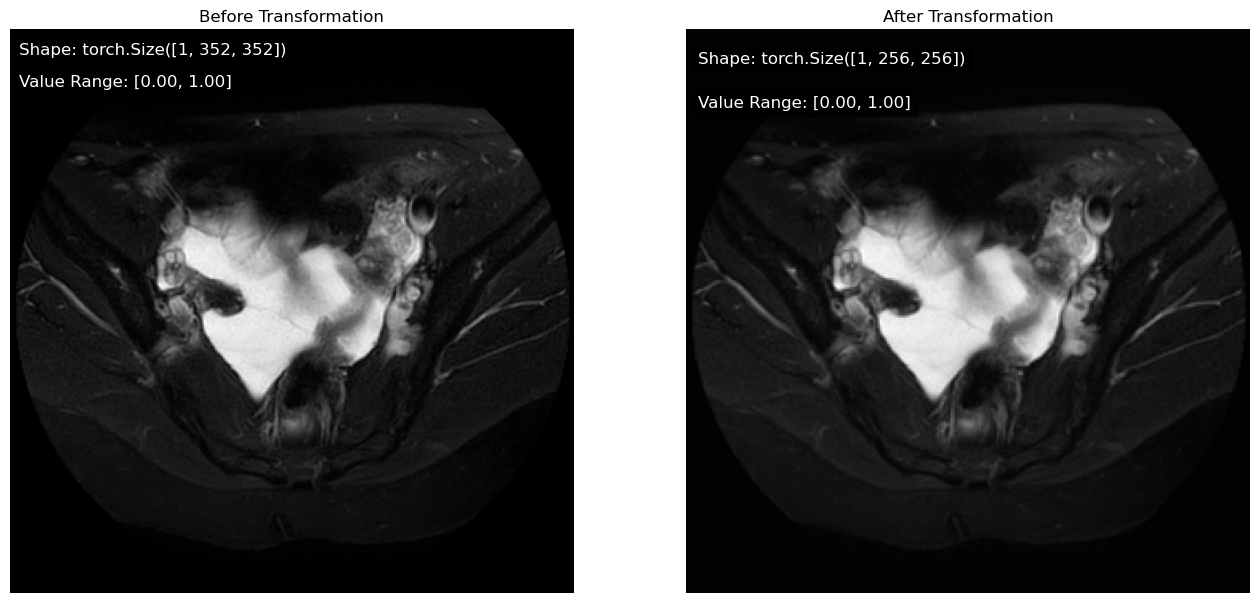

In [17]:
# --- Visualize the Effect of Transformations ---

# Instantiate a dataset WITHOUT transforms to get the original slice
uterus_dataset_original = UterusDataset(manifest_path=manifest_path, transforms=None)

# Get the original sample
original_image_tensor, original_mask_tensor = uterus_dataset_original[sample_idx]

# Get the transformed sample (we already have this from the previous cell)
transformed_image_tensor = image_tensor

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Before Transformation
ax1.imshow(original_image_tensor.squeeze(), cmap='gray')
ax1.set_title("Before Transformation")
ax1.axis('off')
# Add text to show original properties
ax1.text(5, 15, f"Shape: {original_image_tensor.shape}", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax1.text(5, 35, f"Value Range: [{original_image_tensor.min():.2f}, {original_image_tensor.max():.2f}]", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))


# Plot 2: After Transformation
ax2.imshow(transformed_image_tensor.squeeze(), cmap='gray')
ax2.set_title("After Transformation")
ax2.axis('off')
# Add text to show transformed properties
ax2.text(5, 15, f"Shape: {transformed_image_tensor.shape}", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax2.text(5, 35, f"Value Range: [{transformed_image_tensor.min():.2f}, {transformed_image_tensor.max():.2f}]", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()

Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.


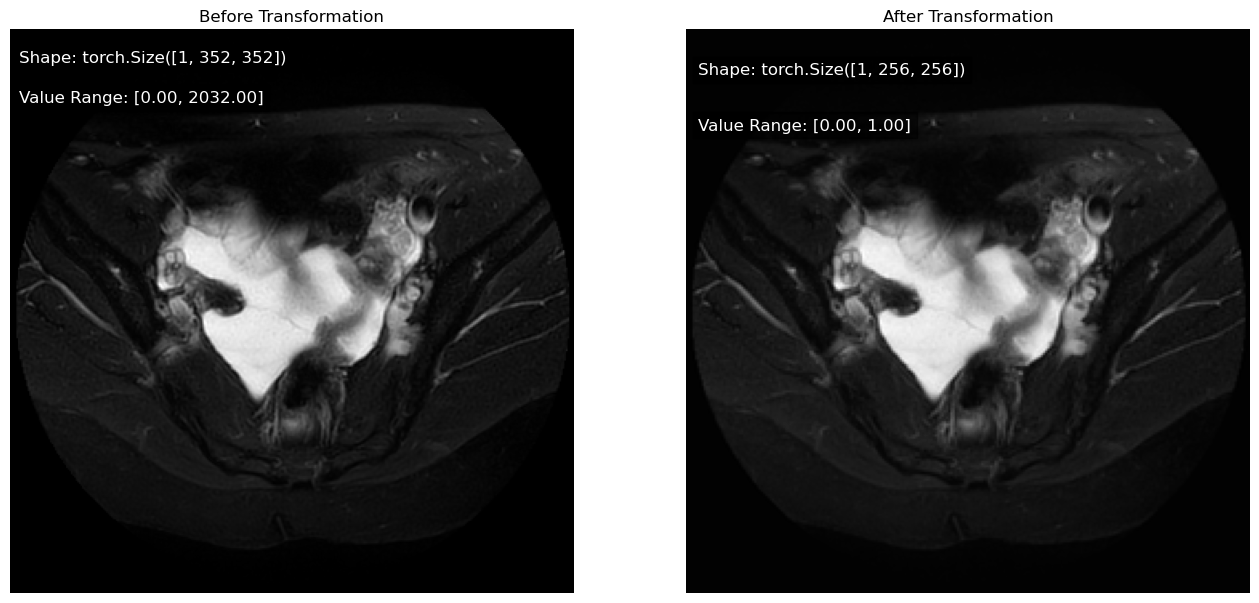

In [19]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class UterusDataset(Dataset):
    """
    PyTorch Dataset for loading 2D slices from 3D MRI scans of the uterus.
    Preprocessing transforms are now handled correctly.
    """
    def __init__(self, manifest_path, transforms=None):
        self.manifest = pd.read_csv(manifest_path)
        self.transforms = transforms
        self.slice_map = []
        
        print("Loading dataset and creating slice map...")
        for patient_index, row in self.manifest.iterrows():
            mask_image = sitk.ReadImage(row['mask_path'])
            num_slices = mask_image.GetSize()[2]
            
            for slice_index in range(num_slices):
                mask_array = sitk.GetArrayFromImage(mask_image)
                if np.sum(mask_array[slice_index, :, :]) > 0:
                    self.slice_map.append({
                        'patient_index': patient_index,
                        'slice_index': slice_index
                    })
        print(f"Slice map created. Found {len(self.slice_map)} slices containing the uterus.")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        slice_info = self.slice_map[idx]
        patient_index = slice_info['patient_index']
        slice_index = slice_info['slice_index']
        
        patient_data = self.manifest.iloc[patient_index]
        mri_path = patient_data['mri_path']
        mask_path = patient_data['mask_path']
        
        mri_image = sitk.ReadImage(mri_path, sitk.sitkFloat32)
        mask_image = sitk.ReadImage(mask_path, sitk.sitkUInt8)
        
        mri_array = sitk.GetArrayFromImage(mri_image)
        mask_array = sitk.GetArrayFromImage(mask_image)
        
        mri_slice = mri_array[slice_index, :, :]
        mask_slice = mask_array[slice_index, :, :]
        
        image_tensor = torch.from_numpy(mri_slice).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_slice).unsqueeze(0).float()
        
        # --- FIX IS HERE ---
        # The normalization logic has been removed from here.
        # It will now be handled by the transforms pipeline.
        
        if self.transforms:
            combined = torch.cat([image_tensor, mask_tensor], dim=0)
            combined_transformed = self.transforms(combined)
            image_tensor = combined_transformed[0, :, :].unsqueeze(0)
            mask_tensor = combined_transformed[1, :, :].unsqueeze(0)

        return image_tensor, mask_tensor

# --- Test the Corrected Visualization ---

# Define the transformations: resize AND then normalize.
# We will use torch.stack to correctly re-combine the image and mask.
data_transforms = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC, antialias=True),
    T.Lambda(lambda x: torch.stack([
        (x[0] - x[0].min()) / (x[0].max() - x[0].min()), # Normalize image (channel 0)
        x[1]                                           # Keep mask (channel 1) as is
    ], dim=0))
])

# 1. Get the UNTRANSFORMED sample
manifest_path = '../data/d2_manifest_t2fs.csv'
uterus_dataset_original = UterusDataset(manifest_path=manifest_path, transforms=None)
sample_idx = 100
original_image_tensor, _ = uterus_dataset_original[sample_idx]

# 2. Get the TRANSFORMED sample
uterus_dataset_transformed = UterusDataset(manifest_path=manifest_path, transforms=data_transforms)
transformed_image_tensor, _ = uterus_dataset_transformed[sample_idx]

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Before Transformation
ax1.imshow(original_image_tensor.squeeze(), cmap='gray')
ax1.set_title("Before Transformation")
ax1.axis('off')
ax1.text(5, 20, f"Shape: {original_image_tensor.shape}", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax1.text(5, 45, f"Value Range: [{original_image_tensor.min():.2f}, {original_image_tensor.max():.2f}]", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

# Plot 2: After Transformation
ax2.imshow(transformed_image_tensor.squeeze(), cmap='gray')
ax2.set_title("After Transformation")
ax2.axis('off')
ax2.text(5, 20, f"Shape: {transformed_image_tensor.shape}", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
ax2.text(5, 45, f"Value Range: [{transformed_image_tensor.min():.2f}, {transformed_image_tensor.max():.2f}]", color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()